## Trabalho Prático 2 - Planejamento e Navegação

Utilizando a estratégia de planejamento de caminhos Roadmap, deve-se utilizar um robô Holonômico.

As carcterísticas de um robô holonômico são: 
- Possuem um número de velocidades atuáveis 

#### Instalando pacotes não habituais utilizados no código

In [1]:
#pip install coppeliasim-zmqremoteapi-client

#!pip install pyvisgraph

### Importando as bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import networkx as nx
from coppeliasim_zmqremoteapi_client import *
import random

import pyvisgraph as vg
from pyvisgraph.visible_vertices import edge_distance
import matplotlib.pyplot as plt
from graph import DiGraph
from algorithms import dijkstra
import homotopy as h
from math import atan2

### Remote API functions (Python)

Criação do cliente para conexão com a api remota

Link para repositório da SimZMQRemoteApi: https://github.com/CoppeliaRobotics/zmqRemoteApi/tree/master/clients/python

In [2]:
# create a client to connect to zmqRemoteApi server:
# (creation arguments can specify different host/port,
# defaults are host='localhost', port=23000)
client = RemoteAPIClient()

# get a remote object:
sim = client.require('sim')

# call API function fo test:
robotino = sim.getObject('/robotino')
print("Printando o robotininho: " + str(robotino))

Printando o robotininho: 13


### Funções auxiliares

In [3]:
# Função para rotacionar em torno do eixo z
def Rz(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])

def get_object_position(sim, object_name):
    return sim.getObjectPosition(sim.getObject(object_name), -1)

def get_object_orientation(sim, object_name):
    return sim.getObjectOrientation(sim.getObject(object_name), -1)

#### Carregando imagem do mapa

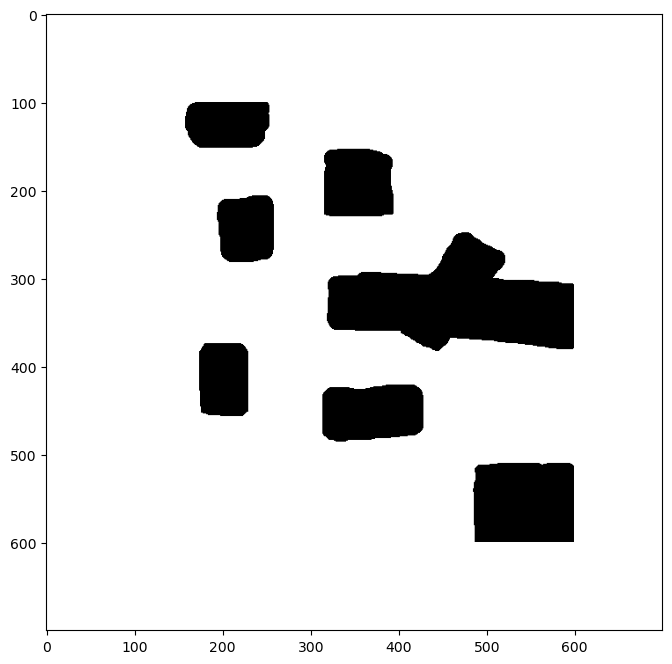

In [4]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Invertendo os valores para visualização (Branco - 0, Preto - 1)
img = 1 - mpimg.imread('cave.png')

# Apenas para garantir que só teremos esses dois valores
threshold = 0.5
img[img > threshold] = 1
img[img<= threshold] = 0

ax.imshow(img, cmap='Greys', origin='upper')

#### Criando o grid com as células binarizadas

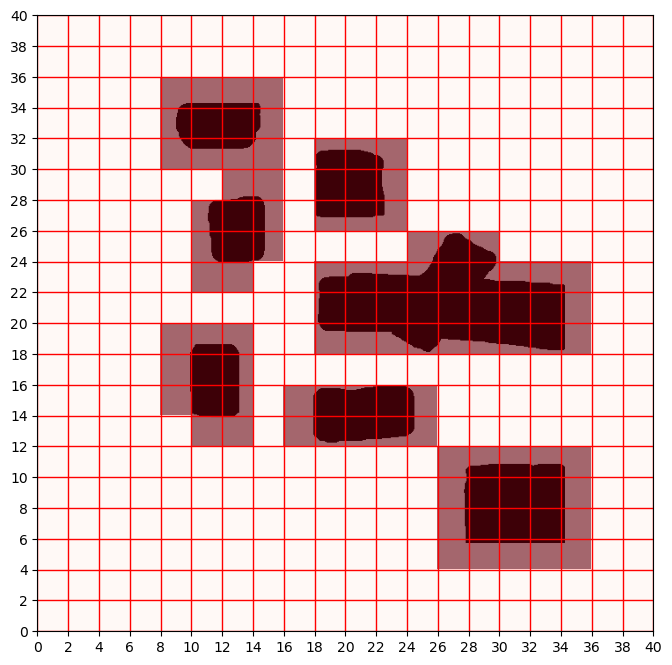

In [5]:
# Dimensões do mapa informado em metros (X, Y)
map_dims = np.array([40, 40]) # Cave 

# Escala Pixel/Metro
sy, sx = img.shape / map_dims

# Tamanho da célula do nosso Grid (em metros)
cell_size = 2

rows, cols = (map_dims / cell_size).astype(int)
grid = np.zeros((rows, cols))

# Preenchendo o Grid
# Cada célula recebe o somatório dos valores dos Pixels
for r in range(rows):
    for c in range(cols):
        
        xi = int(c*cell_size*sx)
        xf = int(xi + cell_size*sx)
        
        yi = int(r*cell_size*sy)
        yf = int(yi + cell_size*sy)
                      
        grid[r, c] = np.sum(img[yi:yf,xi:xf])
        
# Binarizando as células como Ocupadas (1) ou Não-ocupadas (0)       
grid[grid > threshold] = 1
grid[grid<= threshold] = 0        

fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

# Plotando Mapa e Células
obj = ax.imshow(img, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
obj = ax.imshow(grid, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)

# Plotando as linhas do grid para facilitar a visualização
ax.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1)
ax.set_xticks(np.arange(0, map_dims[1]+1, cell_size))
ax.set_yticks(np.arange(0, map_dims[0]+1, cell_size))

### Criando o Grafo para o Grid feito

In [6]:
def draw(polys, centers=[]):
	# Draw the obstacles
	for i in range(0, len(polys)):
		for j in range(0,len(polys[i])-1):
			plt.plot([polys[i][j].x, polys[i][j+1].x], [polys[i][j].y, polys[i][j+1].y], 'b')
		plt.plot([polys[i][0].x, polys[i][len(polys[i])-1].x], [polys[i][0].y, polys[i][len(polys[i])-1].y], 'b')
		if centers:	
			plt.plot(centers[i][0].x, centers[i][0].y, 'ko')
			plt.plot([centers[i][0].x, centers[i][0].x], [centers[i][0].y, centers[i][0].y+100], 'k:')
			plt.text(centers[i][0].x+0.3, centers[i][0].y, str(centers[i][1]))
	plt.axis('equal')
	plt.axis([0, 40,0, 40])
	plt.xlabel("x (m)")
	plt.ylabel("y (m)")


In [7]:
def find_polygons(edges):
    polys = []
    while edges:
        polygon = []
        start_edge = edges.pop(0)
        current_point = start_edge[0]
        polygon.append(current_point)

        while True:
            # Find the next edge
            for edge in edges:
                if edge[0] == current_point:
                    next_point = edge[1]
                    break
                elif edge[1] == current_point:
                    next_point = edge[0]
                    break
            else:
                # No matching edge found, end of polygon
                break
            
            polygon.append(next_point)
            edges.remove(edge)
            current_point = next_point

            # Check if we have returned to the start point
            if current_point == start_edge[0]:
                break
        
        polys.append(polygon)
    return polys

# Função para verificar se uma célula é um contorno
def is_contour_cell(r, c, grid):
    if grid[r][c] == 1:
        # Verificar se há pelo menos um vizinho livre (0)
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < rows and 0 <= nc < cols and grid[nr][nc] == 0:
                return True
    return False

# Função para adicionar pontos do contorno ao array polys
def add_contour_points(r, c, polys):
    # Coordenadas das arestas da célula (c, r)
    top_left = vg.Point(c * cell_size, map_dims[0] - r * cell_size)
    bottom_left = vg.Point(c * cell_size, map_dims[0] - (r + 1) * cell_size)
    bottom_right = vg.Point((c + 1) * cell_size, map_dims[0] - (r + 1) * cell_size)
    top_right = vg.Point((c + 1) * cell_size, map_dims[0] - r * cell_size)

    # Adicionar pontos de contorno
    if r == 0 or grid[r-1][c] == 0:  # Aresta superior
        polys.append(top_left)
        polys.append(top_right)
    if r == rows-1 or grid[r+1][c] == 0:  # Aresta inferior
        polys.append(bottom_right)
        polys.append(bottom_left)
    if c == 0 or grid[r][c-1] == 0:  # Aresta esquerda
        polys.append(bottom_left)
        polys.append(top_left)
    if c == cols-1 or grid[r][c+1] == 0:  # Aresta direita
        polys.append(top_right)
        polys.append(bottom_right)
        
def orientation(p, q, r):
    """Determina a orientação dos pontos p, q, r"""
    val = (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y)
    if val == 0:
        return 0  # Colinear
    return 1 if val > 0 else -1  # Horário ou anti-horário

def graham_scan(points):
    """Encontra o contorno convexo de um conjunto de pontos usando o algoritmo de Graham Scan"""
    # Ordena os pontos por coordenada y (e x em caso de empate)
    points = sorted(points, key=lambda p: (p.y, p.x))

    # Encontra o ponto mais baixo (ou o ponto mais à esquerda em caso de empate)
    pivot = points[0]

    # Ordena os pontos em relação ao ponto pivô
    sorted_points = sorted(points[1:], key=lambda p: (atan2(p.y - pivot.y, p.x - pivot.x), p.x))

    # Constrói o contorno convexo
    hull = [pivot]
    for point in sorted_points:
        while len(hull) > 1 and orientation(hull[-2], hull[-1], point) != -1:
            hull.pop()
        hull.append(point)
    return hull


[Point(8.00, 36.00), Point(8.00, 34.00), Point(8.00, 32.00), Point(8.00, 30.00), Point(10.00, 30.00), Point(12.00, 30.00), Point(12.00, 28.00), Point(10.00, 28.00), Point(10.00, 26.00), Point(10.00, 24.00), Point(10.00, 22.00), Point(12.00, 22.00), Point(14.00, 22.00), Point(14.00, 24.00), Point(16.00, 24.00), Point(16.00, 26.00), Point(16.00, 28.00), Point(16.00, 30.00), Point(16.00, 32.00), Point(16.00, 34.00), Point(16.00, 36.00), Point(14.00, 36.00), Point(12.00, 36.00), Point(10.00, 36.00)]
Vértices da figura: [Point(10.00, 22.00), Point(14.00, 22.00), Point(16.00, 24.00), Point(16.00, 36.00), Point(8.00, 36.00), Point(8.00, 30.00)]
[Point(18.00, 32.00), Point(18.00, 30.00), Point(18.00, 28.00), Point(18.00, 26.00), Point(20.00, 26.00), Point(22.00, 26.00), Point(24.00, 26.00), Point(24.00, 28.00), Point(24.00, 30.00), Point(24.00, 32.00), Point(22.00, 32.00), Point(20.00, 32.00)]
Vértices da figura: [Point(18.00, 26.00), Point(24.00, 26.00), Point(24.00, 32.00), Point(18.00, 32.0

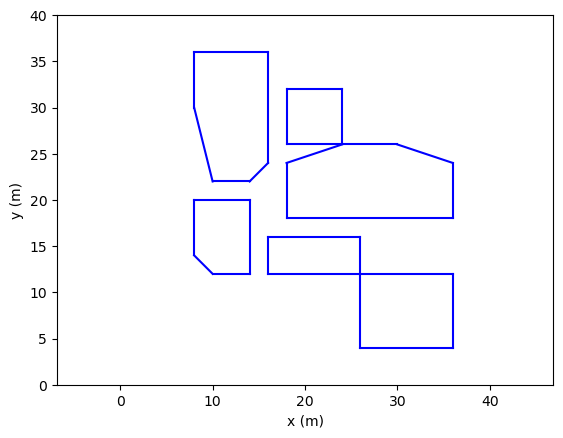

In [8]:
# Criando vértices em todas as células
G = nx.grid_2d_graph(rows, cols) 
polys = []

# Encontrar e adicionar os pontos de contorno
for r in range(rows):
    for c in range(cols):
        if is_contour_cell(r, c, grid):
            add_contour_points(r, c, polys)

# Converte os pontos de contorno em polígonos
polys = [polys[i:i+2] for i in range(0, len(polys), 2)]

polys = find_polygons(polys)

vert = []

for p in polys:
    print(p)
    hull = graham_scan(p)
    print("Vértices da figura:", hull)
    vert.append(hull)

polys = vert

# Desenha os obstáculos
draw(polys)

# Removendo células que estão em células marcadas com obstáculos
for r in range(rows):
    for c in range(cols):
        if grid[r][c] == 1: 
            G.remove_node((r, c))

# Vértices de início e fim
start = (0,0)
end = (rows-1, cols-1)
print("Start:", start)
print("End:", end)

100%|██████████| 3/3 [00:00<00:00, 187.56it/s]
C:\Users\felip\AppData\Local\Temp\ipykernel_8388\3500875704.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.ginput()


Visibility Graph:
Nodenum dictionary: {Point(10.00, 22.00): '1', Point(14.00, 22.00): '2', Point(16.00, 24.00): '3', Point(16.00, 36.00): '4', Point(8.00, 36.00): '5', Point(8.00, 30.00): '6', Point(18.00, 26.00): '7', Point(24.00, 26.00): '15', Point(24.00, 32.00): '9', Point(18.00, 32.00): '10', Point(18.00, 18.00): '11', Point(36.00, 18.00): '12', Point(36.00, 24.00): '13', Point(30.00, 26.00): '14', Point(18.00, 24.00): '16', Point(10.00, 12.00): '17', Point(14.00, 12.00): '18', Point(14.00, 20.00): '19', Point(8.00, 20.00): '20', Point(8.00, 14.00): '21', Point(16.00, 12.00): '22', Point(26.00, 12.00): '29', Point(26.00, 16.00): '24', Point(16.00, 16.00): '25', Point(26.00, 4.00): '26', Point(36.00, 4.00): '27', Point(36.00, 12.00): '28'}
Printando o node:  30
Definindo o ponto de partida:  [6.0, 38.0]
Base position and Goal position:
Shortest path from start to goal: {'cost': 37.80601128932278, 'path': ['30', '1', '11', '31']}


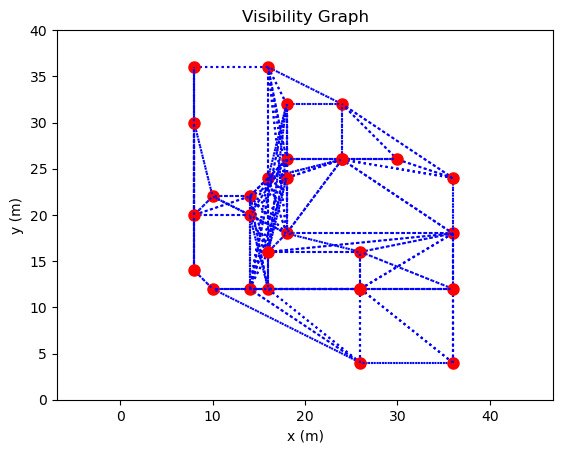

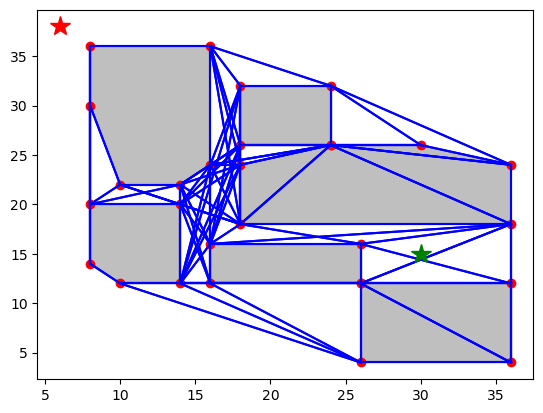

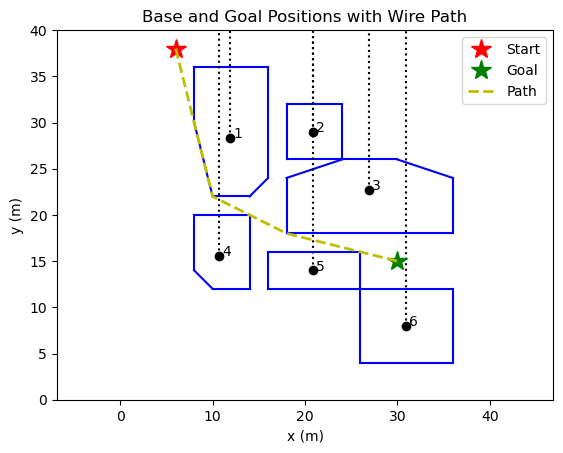

In [9]:
centers = h.findCenters(polys)

plt.figure(2)
plt.title("Centros dos Objetos")
draw(polys, centers)	

# Create the visibility graph
g = vg.VisGraph()  # This is the visibility graph
g.build(polys)

# Plot the visibility graph
plt.figure(1)
print("Visibility Graph:")
for poly in polys: # Para cada polígono na lista de obstáculos
    for vertex in poly: # Para cada vértice no polígono
        for edge in g.visgraph[vertex]: # Para cada aresta no grafo de visibilidade
            adj = edge.get_adjacent(vertex) # Vértice adjacente
            plt.plot([vertex.x, adj.x], [vertex.y, adj.y], 'b:') # Plota a aresta
        plt.plot(vertex.x, vertex.y, 'ro', markersize=8) # Plota o vértice
        
plt.axis('equal')
plt.title("Visibility Graph")
plt.axis([0, 40, 0, 40])
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.ginput()

G = DiGraph()  # Grafo para busca de caminhos
node = 1
nodenum = {}  # Dicionário para transformar posições 2D em rótulos de nós em G (números)

# Create the Graph with nodes only
for i in range(0, len(polys)):
	for j in range(0,len(polys[i])):
		G.add_node(str(node))
		nodenum[polys[i][j]]=str(node)
		node=node+1

print("Nodenum dictionary:", nodenum)

# Create the edges with costs
for i in range(0, len(polys)):
	for j in range(0,len(polys[i])):
		for edges in g.visgraph[polys[i][j]]:
			adj=edges.get_adjacent(polys[i][j])				
			cost = edge_distance(polys[i][j], adj)
			signature = h.Signature(centers, polys[i][j], adj)
			G.add_edge(nodenum[polys[i][j]], nodenum[adj], cost, signature)

print("Printando o node: ", node)

## NEW ADICTION
plt.figure()
for poly in polys:
    x, y = zip(*[(vertex.x, vertex.y) for vertex in poly])
    plt.fill(x, y, color='grey', alpha=0.5)

# Adicione os nós do grafo de visibilidade
for poly in polys:
    for vertex in poly:
        plt.plot(vertex.x, vertex.y, 'ro')  # Desenha os nós como pontos vermelhos

# Adicione as arestas do grafo de visibilidade
for poly in polys:
    for vertex in poly:
        for edge in g.visgraph[vertex]:
            adj = edge.get_adjacent(vertex)
            plt.plot([vertex.x, adj.x], [vertex.y, adj.y], 'b-')  # Desenha as arestas como linhas azuis

# Adicione o ponto inicial e o ponto de destino
start_point = vg.Point(6.0, 38.0)
goal_point = vg.Point(30.0, 15.0)
plt.plot(start_point.x, start_point.y, 'r*', markersize=15, label="Start")
plt.plot(goal_point.x, goal_point.y, 'g*', markersize=15, label="Goal")
## HERE

# Ponto inicial é o ponto âncora
start = [6.0, 38.0]	
print("Definindo o ponto de partida: ", start)
start_point = vg.Point(start[0], start[1])
goal = [30.0, 15.0]  # Defina seu ponto de destino aqui
goal_point = vg.Point(goal[0], goal[1])

# Update the visibility map
g.update([start_point, goal_point], start_point)

# Update the search graph with the start_point
G.add_node(str(node))
nodenum[start_point]=str(node)
node = node + 1
for edges in g.visgraph[start_point]:
	adj=edges.get_adjacent(start_point)
	cost = edge_distance(start_point, adj)
	signature = h.Signature(centers, start_point, adj)
	G.add_edge(nodenum[start_point], nodenum[adj], cost, signature)
	G.add_edge(nodenum[adj], nodenum[start_point], cost, h.Invert(signature))
 
 
# Adicionar o ponto de destino ao grafo
G.add_node(str(node))
nodenum[goal_point] = str(node)
node += 1
for edges in g.visgraph[goal_point]:
    adj = edges.get_adjacent(goal_point)
    cost = edge_distance(goal_point, adj)
    signature = h.Signature(centers, goal_point, adj)
    G.add_edge(nodenum[goal_point], nodenum[adj], cost, signature)
    G.add_edge(nodenum[adj], nodenum[goal_point], cost, h.Invert(signature)) 
 
# Plot the base position
plt.figure(2)
print("Base position and Goal position:")
plt.plot(start_point.x, start_point.y, 'r*', markersize=15, label="Start")
plt.plot(goal_point.x, goal_point.y, 'g*', markersize=15, label="Goal")

# Calculando o caminho mais curto usando Dijkstra
shortest_path = dijkstra(G, nodenum[start_point], nodenum[goal_point])
print("Shortest path from start to goal:", shortest_path)

# Plotando o caminho mais curto
path = shortest_path['path']
path_points = [next(key for key, value in nodenum.items() if value == node) for node in path]
x_coords = [point.x for point in path_points]
y_coords = [point.y for point in path_points]

plt.plot(x_coords, y_coords, 'y--', linewidth=2, label="Path")

plt.title("Base and Goal Positions with Wire Path")
plt.axis('equal')
plt.axis([0, 40, 0, 40])
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.show()

Caminho: ['30', '1', '11', '31']
Custo Total: 37.80601128932278
Coordenadas do Caminho: [Point(6.00, 38.00), Point(10.00, 22.00), Point(18.00, 18.00), Point(30.00, 15.00)]


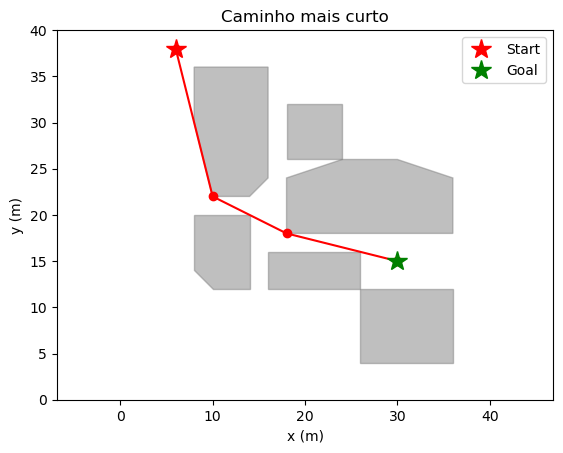

Caminho para o CoppeliaSim: [[-7.0, 9.0], [-5.0, 1.0], [-1.0, -1.0], [5.0, -2.5]]


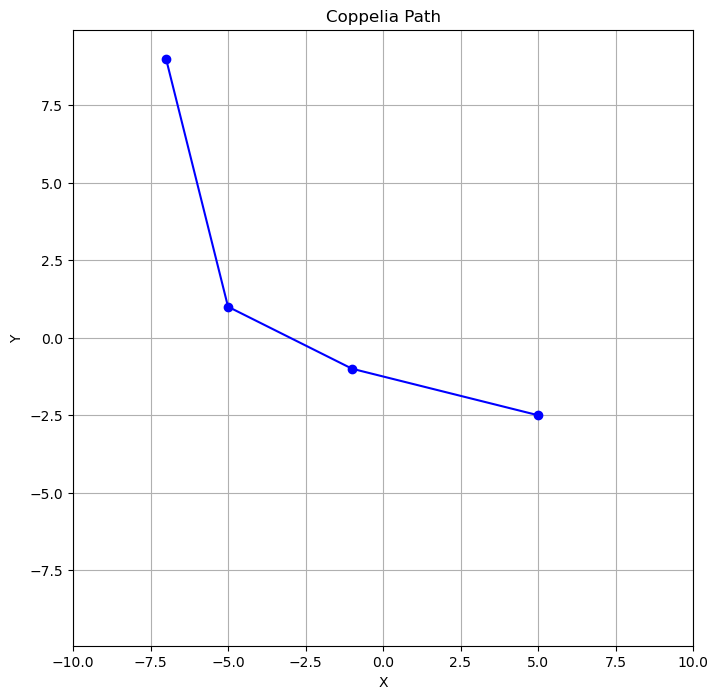

In [10]:
# Extraindo o caminho e custo do resultado
caminho = shortest_path['path']
custo_total = shortest_path['cost']

print("Caminho:", caminho)
print("Custo Total:", custo_total)

# Convertendo o caminho em coordenadas
coordenadas = [next(key for key, value in nodenum.items() if value == node) for node in caminho]
print("Coordenadas do Caminho:", coordenadas)

# Plotando o caminho
plt.figure(3)
for poly in polys:
    x, y = zip(*[(vertex.x, vertex.y) for vertex in poly])
    plt.fill(x, y, color='grey', alpha=0.5)
    
for vertex in coordenadas:
    plt.plot(vertex.x, vertex.y, 'ro')
    
for i in range(len(coordenadas)-1):
    plt.plot([coordenadas[i].x, coordenadas[i+1].x], [coordenadas[i].y, coordenadas[i+1].y], 'r-')
    
plt.plot(start_point.x, start_point.y, 'r*', markersize=15, label="Start")
plt.plot(goal_point.x, goal_point.y, 'g*', markersize=15, label="Goal")
plt.title("Caminho mais curto")
plt.axis('equal')
plt.axis([0, 40, 0, 40])
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.legend()
plt.show()

coppelia_map = [-10, 10, -10, 10]

# Convertendo as coordenadas do caminho para o intervalo do mapa do CoppeliaSim

def convert_to_coppelia(coord, map, coppelia_map):
    x = (coord[0] - map[0]) / (map[1] - map[0]) * (coppelia_map[1] - coppelia_map[0]) + coppelia_map[0]
    y = (coord[1] - map[2]) / (map[3] - map[2]) * (coppelia_map[3] - coppelia_map[2]) + coppelia_map[2]
    return [x, y]

caminho_sim = [convert_to_coppelia([coord.x, coord.y], [0, 40, 0, 40], coppelia_map) for coord in coordenadas]
print("Caminho para o CoppeliaSim:", caminho_sim)
coppeliaPath = np.array(caminho_sim)

# Plotando o caminho do coppelia
plt.figure(figsize=(8, 8))
plt.plot(coppeliaPath[:, 0], coppeliaPath[:, 1], marker='o', color='b')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Coppelia Path')
plt.axis('equal')
plt.axis([-10, 10, -10, 10])
plt.grid(True)
plt.show() 


## Movimentação do robô

In [11]:
# Conectando-se ao CoppeliaSim
# Run a simulation in asynchronous mode:
clientID = sim.startSimulation()


if clientID != -1:
    print("Connected to remote API server")

    # Get the robot's handle
    robotino = sim.getObjectHandle('/robotino')

    # Get the robot's wheels
    wheel1 = sim.getObjectHandle('wheel0_joint')
    wheel2 = sim.getObjectHandle('wheel1_joint')
    wheel3 = sim.getObjectHandle('wheel2_joint')

    # Retirado da aula 07 de navegação 
    # Robotino
    L = 0.135   # Metros
    r = 0.040   # Metros
               
    # Cinemática Direta
    Mdir = np.array([[-r/np.sqrt(3), 0, r/np.sqrt(3)], [r/3, (-2*r)/3, r/3], [r/(3*L), r/(3*L), r/(3*L)]])
                       
    ganho = np.array([[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.1]]) # Ganho do controlador

    # Adicione a coordenada Z se necessário (dependendo da sua aplicação)
    coppeliaPath = np.column_stack((coppeliaPath, np.zeros(len(coppeliaPath))))

for i in range(len(coppeliaPath)):
    # Posição do Robotino
    print("Goal: ", coppeliaPath[-1])

    while True:
        # Posição inicial do Robotino em cena
        robotinoPos = get_object_position(sim, '/robotino')  #start
        robotinoOri = get_object_orientation(sim, '/robotino')
        
        q_robot = np.array([robotinoPos[0], robotinoPos[1], robotinoOri[2]])

        # Calcule o erro entre a posição atual e o próximo ponto do caminho
        error = coppeliaPath[i] - q_robot
        errorNorm = np.linalg.norm(error[:2])

        print("Coppelia: ", q_robot)

        if errorNorm < 0.05:
            print("Goal reached")
            break

        # Calcule o vetor de controle usando o ganho e o erro
        qdot = ganho @ error

        # Calculando a velocidade linear e angular
        Minv = np.linalg.inv(Rz(q_robot[2]) @ Mdir)
        u = Minv @ qdot

        # Enviando velocidades para as rodas
        sim.setJointTargetVelocity(wheel1, 10 * u[0])
        sim.setJointTargetVelocity(wheel2, 10 * u[1])
        sim.setJointTargetVelocity(wheel3, 10 * u[2])

        # Atualizando a posição e orientação do robô
        robotinoPos = sim.getObjectPosition(robotino, -1)
        robotinoOri = sim.getObjectOrientation(robotino, -1)

    # Parando as rodas
    sim.setJointTargetVelocity(wheel1, 0)
    sim.setJointTargetVelocity(wheel2, 0)
    sim.setJointTargetVelocity(wheel3, 0)

pos = sim.getObjectPosition(robotino, -1)
print(pos)

# Stop the simulation:
sim.stopSimulation()

Connected to remote API server
Goal:  [ 5.  -2.5  0. ]
Coppelia:  [-6.99841911e+00  8.99909268e+00  3.01443701e-03]
Goal reached
Goal:  [ 5.  -2.5  0. ]
Coppelia:  [-6.98134387  8.98924685  0.01219043]
Coppelia:  [-6.97885542  8.98098953  0.01030291]
Coppelia:  [-6.97897166e+00  8.96274481e+00  2.16076749e-03]
Coppelia:  [-6.97909697  8.91711475 -0.0202334 ]
Coppelia:  [-6.97986105  8.85371992 -0.08357606]
Coppelia:  [-6.98476929  8.72116371 -0.1367178 ]
Coppelia:  [-6.99145793  8.63058034 -0.224582  ]
Coppelia:  [-7.01150014  8.46869146 -0.39016012]
Coppelia:  [-7.03606083  8.3343794  -0.48166538]
Coppelia:  [-7.03864964  8.2006818  -0.58127452]
Coppelia:  [-7.01840309  8.06589197 -0.65424811]
Coppelia:  [-6.97607435  7.89373341 -0.70161145]
Coppelia:  [-6.95633579  7.82368956 -0.72091536]
Coppelia:  [-6.91435068  7.68191952 -0.7257714 ]
Coppelia:  [-6.88143777  7.57452192 -0.71425121]
Coppelia:  [-6.82390549  7.39466861 -0.66722523]
Coppelia:  [-6.74831536  7.17982582 -0.56691264]
Co